In [277]:
using Images, Plots, Plots.Measures
using FFTW, WAV
using DataFrames, CSV; ENV["COLUMNS"]=500
using JuMP, GLPK, Ipopt
using Statistics: mean, std, cor
using LinearAlgebra

movingaverage(g, n) = [i < n ? mean(g[begin:i]) : mean(g[i-n+1:i]) for i in 1:length(g)]

movingaverage (generic function with 1 method)

## Most natural signals are sparse in a certain basis

1D example

In [342]:
sampled_audio = wavread("piano.wav")[1][begin:2000, 1]
sampled_audio .-= mean(sampled_audio);

In [343]:
function compress_audio(sampled_audio::Vector; ratio=10)
    transformed_audio = fft(sampled_audio)
    L = length(transformed_audio)
    keep_idx = partialsortperm(abs.(transformed_audio), 1:L÷10, rev=true)
    
    compressed_transform = zeros(ComplexF64, L)
    compressed_transform[keep_idx] = transformed_audio[keep_idx]
    
    compressed_audio = real.(ifft(compressed_transform))
    
    return transformed_audio, compressed_transform, compressed_audio
end

transformed_audio, compressed_transform, compressed_audio = compress_audio(sampled_audio);

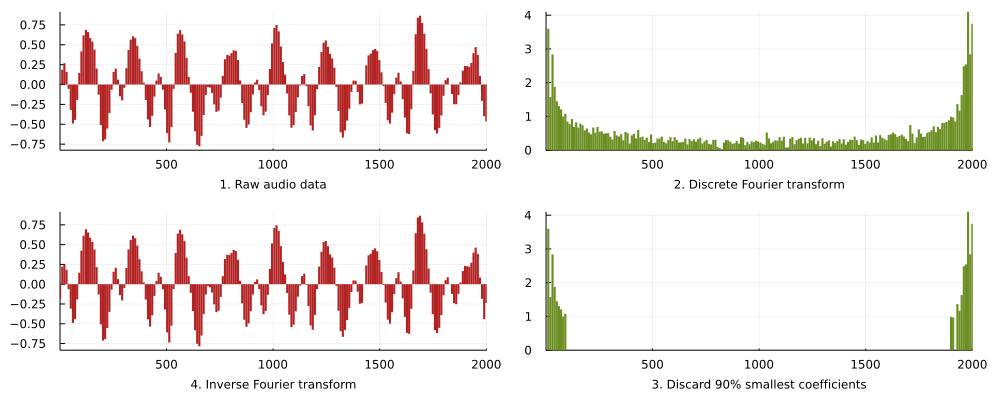

In [344]:
L = length(sampled_audio)
P = 200
pl = plot(layout=4, size=(1000, 400), xlim=(0.5, L+0.5), legend=false, labelfontsize=8, bottommargin=5mm, rightmargin=5mm)

samples_to_plot = round.(Int, range(1, L, length=P))
bar!(pl[1], samples_to_plot, sampled_audio[samples_to_plot],
     lc=nothing, bar_width=ceil(L/P), c=:firebrick, xlabel="1. Raw audio data")
bar!(pl[2], samples_to_plot, log1p.(abs.(transformed_audio[samples_to_plot])), ylim=(0, 4.1),
     lc=nothing, bar_width=ceil(L/P), c=:olivedrab, xlabel="2. Discrete Fourier transform")
bar!(pl[3], samples_to_plot, compressed_audio[samples_to_plot],
     lc=nothing, bar_width=ceil(L/P), c=:firebrick, xlabel="4. Inverse Fourier transform")
bar!(pl[4], samples_to_plot, log1p.(abs.(compressed_transform[samples_to_plot])), ylim=(0, 4.1),
     lc=nothing, bar_width=ceil(L/P), c=:olivedrab, xlabel="3. Discard 90% smallest coefficients")

# savefig(pl, "plots/audio-compression.pdf")

pl

2D example

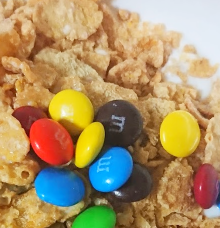

In [345]:
raw_image = load("breakfast.tif")

In [346]:
function compress_image(sampled_image; ratio=10)
    image_as_array = channelview(raw_image)
    nc, nx, ny = size(image_as_array)
    
    transformed_image = dct(image_as_array, (2, 3))
    L = nc * nx * ny
    keep_idx = partialsortperm(abs.(transformed_image[:]), 1:L÷10, rev=true)
    
    compressed_transform = zeros(ComplexF64, nc, nx, ny)
    compressed_transform[keep_idx] = transformed_image[keep_idx]
    
    compressed_image = colorview(RGB, real.(idct(compressed_transform, (2, 3))))
    
    return transformed_image, compressed_transform, compressed_image
end

transformed_image, compressed_transform, compressed_image = compress_image(raw_image);

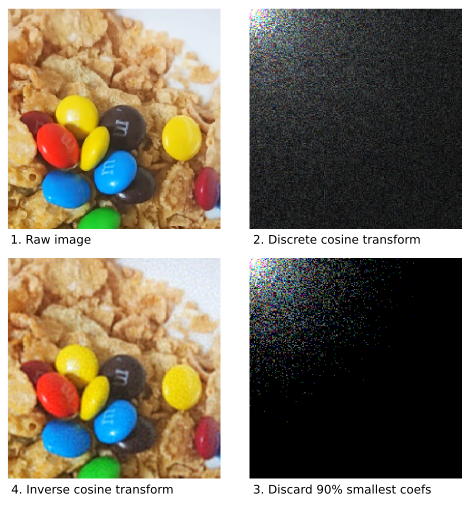

In [347]:
sp = 30
nx, ny = size(raw_image)

concated =
[ raw_image            Gray.(ones(nx, sp))  colorview(RGB, permutedims(cat([sqrt.(abs.(transformed_image[i, :, :])) for i in 1:3]..., dims=3), (3, 1, 2)))
  Gray.(ones(sp, ny))  Gray.(ones(sp, sp))  Gray.(ones(sp, ny))
  compressed_image     Gray.(ones(nx, sp))  colorview(RGB, permutedims(cat([sqrt.(abs.(compressed_transform[i, :, :])) for i in 1:3]..., dims=3), (3, 1, 2)))
  Gray.(ones(sp, ny))  Gray.(ones(sp, sp))  Gray.(ones(sp, ny))   ]

pl = plot(concated, ticks=false, margin=0mm, axis=false, grid=false, size=reverse(size(concated)))

annotate!(pl,[
        (5, nx+5, text("1. Raw image", :left, :top, 8)),
        (ny+sp+5, nx+5, text("2. Discrete cosine transform", :left, :top, 8)),
        (5, 2nx+sp+5, text("4. Inverse cosine transform", :left, :top, 8)),
        (ny+sp+5, 2nx+sp+5, text("3. Discard 90% smallest coefs", :left, :top, 8)),
        ])

# savefig(pl, "plots/image-compression.pdf")

pl

## $L_1$ norm induces sparsity

Data source: https://www.kaggle.com/samsonqian/college-admissions

In [366]:
cols = [ "Name" # Of college
         "Graduation rate - Bachelor degree within 6 years, total" # Column to predict
         "SAT Critical Reading 25th percentile score" # Inputs
         "SAT Critical Reading 75th percentile score"
         "SAT Math 25th percentile score"
         "SAT Math 75th percentile score"
         "SAT Writing 25th percentile score"
         "SAT Writing 75th percentile score"
         "ACT Composite 25th percentile score"
         "ACT Composite 75th percentile score"
         "Tuition and fees, 2010-11"
         "Tuition and fees, 2011-12"
         "Tuition and fees, 2012-13"
         "Tuition and fees, 2013-14"
         "Total price for in-state students living on campus 2013-14"
         "Total price for out-of-state students living on campus 2013-14"
         "Percent of freshmen receiving any financial aid"
         "Percent of freshmen receiving federal, state, local or institutional grant aid"
         "Percent of freshmen  receiving federal grant aid"
         "Percent of freshmen receiving Pell grants"
         "Percent of freshmen receiving other federal grant aid"
         "Percent of freshmen receiving state/local grant aid"
         "Percent of freshmen receiving institutional grant aid"
         "Percent of freshmen receiving student loan aid"
         "Percent of freshmen receiving federal student loans"
         "Percent of freshmen receiving other loan aid"
        ]

admitstats = (CSV.File("admitstats_raw.csv") |> DataFrame)[!, cols]
admitstats = admitstats[completecases(admitstats), :]
rename!(admitstats, vcat("name", "y", ["x$i" for i in 1:length(cols)-2]));
@show size(admitstats)
regression = DataFrame(Pair(:variable, vcat("6-year graduation rate: r^2", cols[3:end])), Pair(:symbol, vcat("y", ["x_$i" for i in 1:length(cols)-2])));
admitstats[begin:10, :]

┌ Warning: thread = 1 warning: only found 107 / 108 columns around data row: 1535. Filling remaining columns with `missing`
└ @ CSV C:\Users\Max\.julia\packages\CSV\CJfFO\src\file.jl:605


size(admitstats) = (656, 26)


10×26 DataFrame
 Row │ name                               y       x1      x2      x3      x4      x5      x6      x7      x8      x9      x10     x11     x12     x13     x14     x15     x16     x17     x18     x19     x20     x21     x22     x23     x24    
     │ String                             Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64? 
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ The University of Alabama              67     490     620     500     640     480     600      22      30    7900    8600    9200    9450   27000   41500      75      60      20      18       4       3      50      42      41       8
   2 │ Auburn University                      68     520     620     540     650     510     620      24      30    7900    8698    9446    9852   25282   41794      76      68      13      13       3       1      65      32      31       3
   3 │ Judson College                         41     550     640     500     600     530     610      19      24   13900   14460   15100   15630   28840   28840     100     100      82      64      18      84     100      83      83      12
   4 │ University of Montevallo               45     495     613     465     550     440     580      20      26    7750    8520    9280   10000   23340   33030      88      80      38      38       5       1      63      55      55       3
   5 │ Samford University                     69     500     630     510     610     500     610      23      28   21942   23963   25150   26328   40900   40900      98      98      14      14      10      23      97      40      39       4
   6 │ University of South Alabama            33     440     550     435     565     420     520      20      26    5748    6204    6660    6948   19980   26628      91      80      45      43      17       5      54      63      63       3
   7 │ Spring Hill College                    56     480     600     480     600     480     610      21      27   26730   28060   29450   30924   46170   46170     100     100      34      33      32      27     100      64      63       3
   8 │ Alaska Pacific University              40     465     575     450     510     435     568      20      24   26360   27110   29810   29810   43180   43180     100     100      42      42      15      15     100      58      58       4
   9 │ University of Arizona                  61     483     600     500     630     480     590      21      27    8237   10035   10035   10391   25179   42171      83      75      30      30       0       0      72      37      36       3
  10 │ Embry-Riddle Aeronautical Univer…      59     500     630     540     650     490     600      23      29   29428   29552   30420   31034   46314   46314      91      90      20      20       0       0      90      61      60      16

In [353]:
X = Array{Float64}(admitstats[:, 3:end])
X .-= mean(X, dims=1)
X ./= std(X, dims=1)

y = Vector{Float64}(admitstats[:, 2])

ā = X\y
regression[:, "λ = 0"] = round.(vcat(cor(X * ā, y)^2, ā), digits=3);

In [354]:
N, M = size(X)
lambdas = [2 ^ i for i in 0:3:12]
â = zeros(M, length(lambdas))

for (i, lambda) in enumerate(lambdas)
    @show lambda
    model = Model(Ipopt.Optimizer)
    set_silent(model)
    @variable(model, a[1:M])
    @variable(model, t[1:M])
    @objective(model, Min, sum( (X * a - y) .^2 )/lambda + sum(t))
    @constraint(model, tAbs1[i in 1:M], t[i] ≥ a[i])
    @constraint(model, tAbs2[i in 1:M], t[i] ≥ -a[i])

    optimize!(model)
    â = value.(a)
    regression[:, "λ = $lambda"] = round.(vcat(cor(X * â, y)^2, â), digits=3);
end

lambda = 1
lambda = 8
lambda = 64
lambda = 512
lambda = 4096


In [355]:
regression

25×8 DataFrame
 Row │ variable                           symbol  λ = 0    λ = 1    λ = 8    λ = 64   λ = 512  λ = 4096 
     │ String                             String  Float64  Float64  Float64  Float64  Float64  Float64  
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 6-year graduation rate: r^2        y         0.836    0.836    0.836    0.828    0.813     0.809
   2 │ SAT Critical Reading 25th percen…  x_1      -2.875   -2.819   -2.663   -0.829    0.0       0.0
   3 │ SAT Critical Reading 75th percen…  x_2      -2.415   -2.418   -2.272   -1.153    0.0       0.0
   4 │ SAT Math 25th percentile score     x_3       3.226    3.181    3.068    2.59     3.02      2.725
   5 │ SAT Math 75th percentile score     x_4      -0.181   -0.115    0.0      0.452    0.453     0.139
   6 │ SAT Writing 25th percentile score  x_5       5.523    5.49     5.321    3.894    2.703     2.345
   7 │ SAT Writing 75th percentile score  x_6       3.332    3.304    3.204    2.227    1.267     0.96
   8 │ ACT Composite 25th percentile sc…  x_7       2.171    2.137    2.049    1.78     1.094     1.383
   9 │ ACT Composite 75th percentile sc…  x_8       1.595    1.612    1.664    1.656    1.75      1.415
  10 │ Tuition and fees, 2010-11          x_9     -24.544  -23.36   -15.669   -0.0      0.0       0.0
  11 │ Tuition and fees, 2011-12          x_10     14.41    13.263    5.268   -0.0      0.0       0.0
  ⋮  │                 ⋮                    ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮
  16 │ Percent of freshmen receiving an…  x_15      1.626    1.611    1.502    0.594   -0.0      -0.0
  17 │ Percent of freshmen receiving fe…  x_16     -4.224   -4.203   -4.053   -2.805   -0.186    -0.0
  18 │ Percent of freshmen  receiving f…  x_17     -2.407   -2.433   -2.514   -3.286   -3.608    -2.55
  19 │ Percent of freshmen receiving Pe…  x_18     -2.171   -2.142   -2.06    -1.003   -0.766    -0.938
  20 │ Percent of freshmen receiving ot…  x_19     -0.345   -0.343   -0.314   -0.167   -0.0      -0.0
  21 │ Percent of freshmen receiving st…  x_20      1.178    1.17     1.132    0.809    0.0      -0.0
  22 │ Percent of freshmen receiving in…  x_21      1.995    1.993    1.995    1.851    0.0       0.0
  23 │ Percent of freshmen receiving st…  x_22     -0.6     -0.397    0.0      0.683    0.0      -0.0
  24 │ Percent of freshmen receiving fe…  x_23      1.557    1.36     0.968    0.0      0.0      -0.0
  25 │ Percent of freshmen receiving ot…  x_24      0.864    0.854    0.83     0.878    0.66      0.0
                                                                                          4 rows omitted

## Compressed sensing

In [356]:
L = 500
real_audio = wavread("piano.wav")[1][4000:3999+L, 1]
real_audio .-= mean(real_audio)
sampling_density = 0.15
sampling_matrix = rand(size(real_audio)...) .< sampling_density
sampled_audio = real_audio .* sampling_matrix;

In [357]:
function optimizer(sampled_audio, sampling_matrix; epsilon=1e-2)
    L = length(sampled_audio)
    IDCT = idct(I(L), 1)
    
    model = Model(GLPK.Optimizer)
    
    @variable(model, fft_pred[1:L]) 
    @variable(model, t[1:L])
    
    @constraint(model, tAbs1[i in 1:L], t[i] ≥ fft_pred[i])
    @constraint(model, tAbs2[i in 1:L], t[i] ≥ - fft_pred[i])
        
    for i in 1:L
        if sampling_matrix[i]
            @constraint(model, (IDCT * fft_pred)[i] - epsilon ≤ sampled_audio[i])
            @constraint(model, (IDCT * fft_pred)[i] + epsilon ≥ sampled_audio[i])
        end
    end
    
    @objective(model, Min, sum(t))
        
    optimize!(model)
    print(solution_summary(model))
    
    return value.(fft_pred), IDCT * (value.(fft_pred))
end

optimizer (generic function with 1 method)

In [358]:
@time fft_pred, audio_pred = optimizer(sampled_audio, sampling_matrix);

* Solver : GLPK

* Status
  Termination status : OPTIMAL
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Message from the solver:
  "Solution is optimal"

* Candidate solution
  Objective value      : 23.78097483740108
  Objective bound      : -Inf
  Dual objective value : 23.780974837401082

* Work counters
  Solve time (sec)   : 0.16800
  7.736301 seconds (2.34 M allocations: 2.125 GiB, 4.96% gc time, 6.24% compilation time)


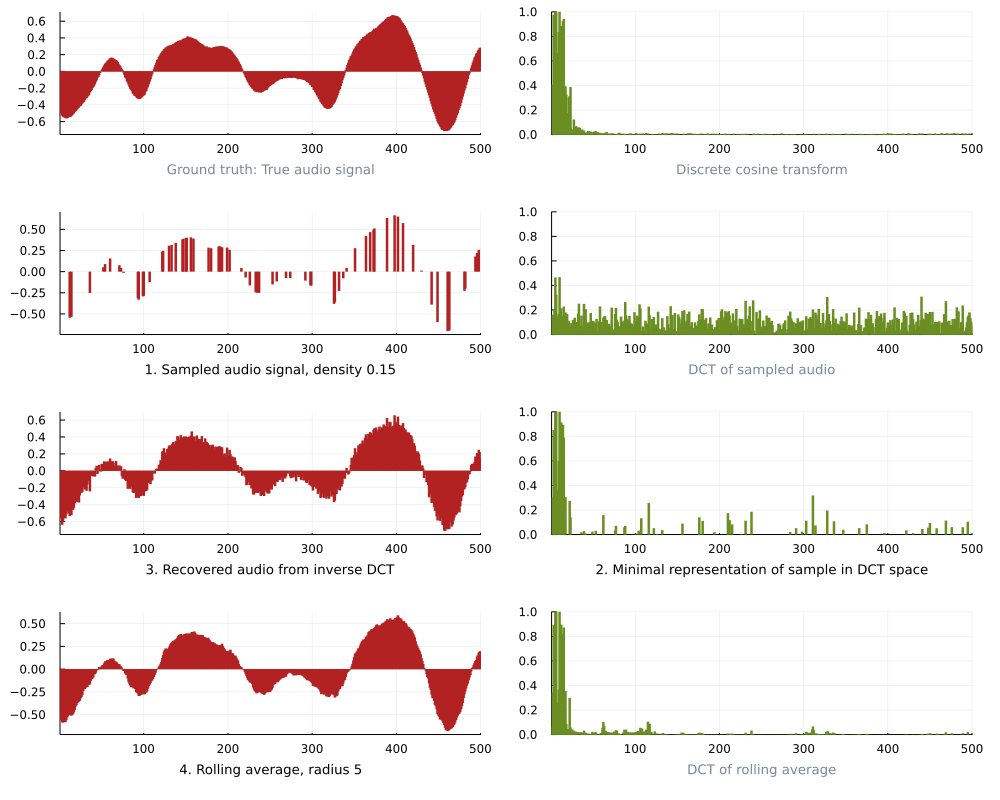

In [359]:
pl = plot(layout=(4, 2), size=(1000, 800), xlim=(0.5, L+0.5), legend=false, labelfontsize=9, bottommargin=5mm, rightmargin=5mm)
rad = 5
ma = movingaverage(audio_pred, rad)
ub = 1

bar!(pl[1], real_audio,
     lc=nothing, bar_width=ceil(L/P), c=:firebrick, xlabel="Ground truth: True audio signal", xguidefontcolor=:lightslategray)
bar!(pl[2], log1p.(abs.(dct(real_audio))), ylim=(0, ub),
     lc=nothing, bar_width=ceil(L/P), c=:olivedrab, xlabel="Discrete cosine transform", xguidefontcolor=:lightslategray)
bar!(pl[3], sampled_audio,
     lc=nothing, bar_width=ceil(L/P), c=:firebrick, xlabel="1. Sampled audio signal, density $sampling_density")
bar!(pl[4], log1p.(abs.(dct(sampled_audio))), ylim=(0, ub),
     lc=nothing, bar_width=ceil(L/P), c=:olivedrab, xlabel="DCT of sampled audio", xguidefontcolor=:lightslategray)
bar!(pl[5], audio_pred,
     lc=nothing, bar_width=ceil(L/P), c=:firebrick, xlabel="3. Recovered audio from inverse DCT")
bar!(pl[6], log1p.(abs.(fft_pred)), ylim=(0, ub),
     lc=nothing, bar_width=ceil(L/P), c=:olivedrab, xlabel="2. Minimal representation of sample in DCT space")
bar!(pl[7], ma,
     lc=nothing, bar_width=ceil(L/P), c=:firebrick, xlabel="4. Rolling average, radius $rad")
bar!(pl[8], log1p.(abs.(dct(ma))), ylim=(0, ub),
     lc=nothing, bar_width=ceil(L/P), c=:olivedrab, xlabel="DCT of rolling average", xguidefontcolor=:lightslategray)

savefig(pl, "plots/audio-recovery.pdf")

pl

2D example

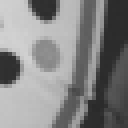

In [360]:
img = Gray.(load("balloon.tif"))

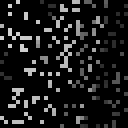

In [361]:
U = Float16
sampling_density = 0.2
sampling_matrix = rand(U, size(img)) .< sampling_density
sampled_image = sampling_matrix .* img
# Vector form is building[sampling_matrix]

In [325]:
function optimizer(sampled_image, sampling_matrix; lambda = 5., epsilon=2e-2)
    U = Float16
    
    image_as_array = convert(Array{U}, channelview(sampled_image))
    
    # For grayscale input
    if ndims(image_as_array) == 2
        image_as_array = reshape(image_as_array, 1, size(image_as_array)...)
    end
    
    nsamples = sum(sampling_matrix)
    nc, nx, ny = size(image_as_array)
    
    IDCTx = idct(I(nx), 1)
    IDCTy = idct(I(ny), 2)
    
    model = Model(GLPK.Optimizer)
    set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_ALL)
    
    @variable(model, fft_pred[1:nc, 1:nx, 1:ny]) 
    @variable(model, t[1:nc, 1:nx, 1:ny])
    
    @constraint(model, tAbs1[i in 1:nc, j in 1:nx, k in 1:ny],
                - t[i, j, k] ≤ fft_pred[i, j, k])
    @constraint(model, tAbs2[i in 1:nc, j in 1:nx, k in 1:ny],
                fft_pred[i, j, k] ≤ t[i, j, k])
        
    for j in 1:nx, k in 1:ny
        if sampling_matrix[j, k]
            for ch in 1:nc
                @constraint(model, (IDCTx * fft_pred[ch, :, :] * IDCTy)[j, k]
                                    - epsilon ≤ image_as_array[ch, j, k])
                @constraint(model, (IDCTx * fft_pred[ch, :, :] * IDCTy)[j, k]
                                    + epsilon ≥ image_as_array[ch, j, k])
            end
        end
    end
    
    @objective(model, Min, sum(t))
        
    optimize!(model)
    print(solution_summary(model))
    
    if ndims(image_as_array) == 
        return value.(fft_pred), Gray.(idct(value.(fft_pred[1, :, :])))
    else
        return value.(fft_pred), colorview(RGB, idct(value.(fft_pred), (2, 3)))
    end
end

optimizer (generic function with 1 method)

In [326]:
@time res, reconstructed_img = optimizer(sampled_image, sampling_matrix);

GLPK Simplex Optimizer 5.0
2480 rows, 2048 columns, 446464 non-zeros
      0: obj =  0.000000000e+000 inf =  1.104e+002 (216)
    897: obj =  1.072494044e+002 inf =  0.000e+000 (0) 5
Perturbing LP to avoid stalling [1725]...
Removing LP perturbation [3075]...
*  3075: obj =  5.479350110e+001 inf =  0.000e+000 (0) 15
OPTIMAL LP SOLUTION FOUND
* Solver : GLPK

* Status
  Termination status : OPTIMAL
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Message from the solver:
  "Solution is optimal"

* Candidate solution
  Objective value      : 54.793501098343036
  Objective bound      : -Inf
  Dual objective value : 54.7935010983431

* Work counters
  Solve time (sec)   : 4.09300
 62.944838 seconds (21.22 M allocations: 32.316 GiB, 8.46% gc time, 0.76% compilation time)


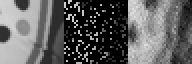

In [35]:
[img sampled_image reconstructed_image]

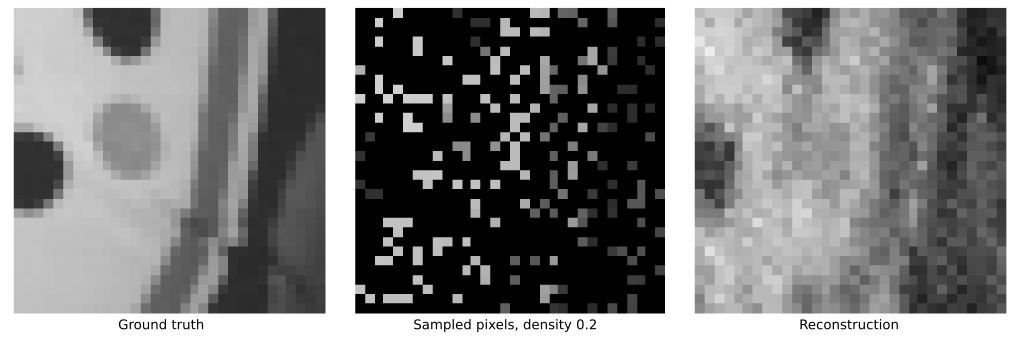

In [365]:
sp = 3
nx, ny = size(img)

concated =
[ img                  Gray.(ones(nx, sp))  sampled_image  Gray.(ones(nx, sp))  reconstructed_img
  Gray.(ones(sp, ny))  Gray.(ones(sp, sp))  Gray.(ones(sp, ny))  Gray.(ones(sp, sp))  Gray.(ones(sp, ny)) ]

scale = 10
pl = plot(concated, ticks=false, margin=0mm, axis=false, grid=false, size=scale .* reverse(size(concated)))

annotate!(pl,[
            (ny/2, nx+5/scale, text("Ground truth", :hcenter, :top, 9)),
            (1.5ny+sp, nx+5/scale, text("Sampled pixels, density $sampling_density", :hcenter, :top, 9)),
            (2.5ny+2sp, nx+5/scale, text("Reconstruction", :hcenter, :top, 9)),
        ])

# savefig(pl, "plots/image-recovery.pdf")

pl

In [338]:
5/scale

0.5

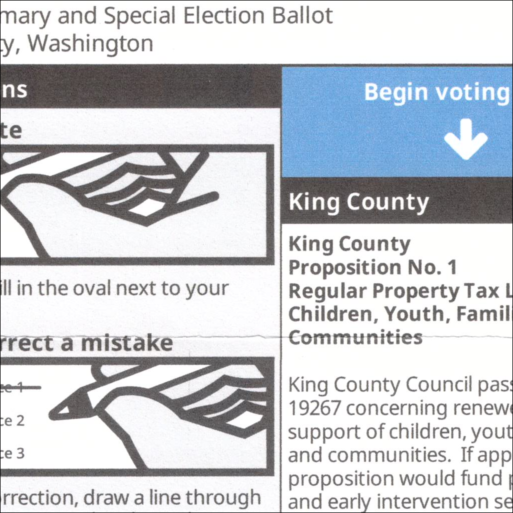

In [2]:
ballot = load("ballot.tif")